In [1]:
import json
import numpy as np
import cv2
from matplotlib import pyplot as plt
from pycocotools import mask as mutils
from tqdm import tqdm
import pandas as pd
import os

In [2]:
filepath = 'result_segm.json'

In [3]:
with open(filepath) as json_file:
    json_data = json.load(json_file)

In [4]:
def rle_encode(mask):
    pixels = mask.T.flatten()
    # We need to allow for cases where there is a '1' at either end of the sequence.
    # We do this by padding with a zero at each end when needed.
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    return rle


def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)


# Used only for testing.
# This is copied from https://www.kaggle.com/paulorzp/run-length-encode-and-decode.
# Thanks to Paulo Pinto.
def rle_decode(rle_str, mask_shape, mask_dtype):
    s = rle_str.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    mask = np.zeros(np.prod(mask_shape), dtype=mask_dtype)
    for lo, hi in zip(starts, ends):
        mask[lo:hi] = 1
    return mask.reshape(mask_shape[::-1]).T

def rle_to_mask(rle_list, SHAPE):
    tmp_flat = np.zeros(SHAPE[0]*SHAPE[1])
    if len(rle_list) == 1:
        mask = np.reshape(tmp_flat, SHAPE).T
    else:
        strt = rle_list[::2]
        length = rle_list[1::2]
        for i,v in zip(strt,length):
            tmp_flat[(int(i)-1):(int(i)-1)+int(v)] = 255
        mask = np.reshape(tmp_flat, SHAPE).T
    return mask

In [20]:
encoded_pixels = []
img_ids = []
height = []
width = []
category_ids = []

for i in tqdm(range(len(json_data))):
    print(type(mutils.decode(json_data[i]['segmentation'])))
    break
    encoded_pixels.append(rle_to_string(rle_encode(mutils.decode(json_data[i]['segmentation']))))
    img_ids.append(json_data[i]['image_id'])
    category_ids.append(json_data[i]['category_id'])
    height.append(json_data[i]['segmentation']['size'][0])
    width.append(json_data[i]['segmentation']['size'][1])

  0%|          | 0/36455 [00:00<?, ?it/s]

<class 'numpy.ndarray'>


In [6]:
data = {'ImageId': img_ids,
        'EncodedPixels': encoded_pixels,
        'Height': height,
        'Width': width,
        'CategoryId': category_ids}

In [7]:
submission = pd.DataFrame(data)
answer_dummy = submission.sample(50)

In [8]:
submission.head()

,ImageId,EncodedPixels,Height,Width,CategoryId
0,0,89689 11 90200 23 90224 3 90711 32 91223 37 91...,512,512,1
1,0,87640 1 88151 11 88662 18 89174 29 89685 36 90...,512,512,2
2,0,87123 11 87633 17 88139 27 88650 33 89161 42 8...,512,512,2
3,0,106094 19 106598 31 107106 38 107614 45 108124...,512,512,2
4,0,90629 7 91140 10 91652 10 92163 11 92675 12 93...,512,512,2


In [16]:
submission['EncodedPixels'][3]

'106094 19 106598 31 107106 38 107614 45 108124 48 108635 50 109144 54 109651 60 110162 62 110675 62 111186 64 111696 67 112208 68 112721 67 113233 68 113745 69 114258 69 114771 69 115283 71 115795 73 116309 73 116822 77 117335 84 117847 88 118361 93 118875 94 119387 96 119900 97 120413 98 120927 98 121440 96 121953 94 122466 92 122979 89 123492 82 124004 77 124517 74 125030 71 125543 67 126056 65 126569 62 127084 57 127598 53 128112 48 128626 44 129148 30'

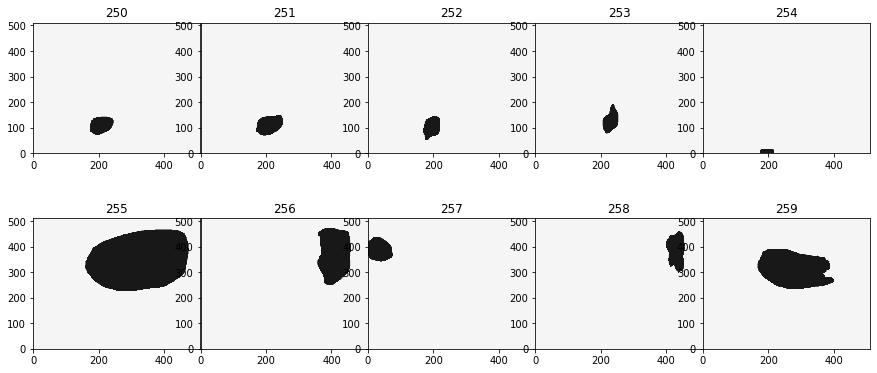

In [10]:
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

for i in range(10):

    axs[i].contourf(rle_to_mask(submission['EncodedPixels'][i].split(), (int(submission['Height'][i]), int(submission['Width'][i]))),5,cmap=plt.cm.Greys)
    axs[i].set_title(str(250+i))

In [11]:
answer_dummy.head()

,ImageId,EncodedPixels,Height,Width,CategoryId
12396,256,1175 9 1684 14 2192 21 2703 26 3214 28 3725 30...,512,512,8
24248,570,42917 4 43418 25 43928 29 44439 31 44943 40 45...,512,512,2
18296,414,45519 2 46030 3 46542 4 47053 6 47564 7 48075 ...,512,512,2
17226,373,247566 14 248076 17 248587 19 249098 19 249610...,512,512,6
1380,62,34506 17 35000 52 35509 59 36018 65 36528 76 3...,512,512,1


In [12]:
class_colormap = pd.read_csv("class_dict.csv")
class_colormap

,name,r,g,b
0,Backgroud,0,0,0
1,General trash,192,0,128
2,Paper,0,128,192
3,Paper pack,0,128,64
4,Metal,128,0,0
5,Glass,64,0,128
6,Plastic,64,0,192
7,Styrofoam,192,128,64
8,Plastic bag,192,192,128
9,Battery,64,64,128


In [13]:
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((11, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):
    """Adds color defined by the dataset colormap to the label.

    Args:
        label: A 2D array with integer type, storing the segmentation label.

    Returns:
        result: A 2D array with floating type. The element of the array
                is the color indexed by the corresponding element in the input label
                to the trash color map.

    Raises:
        ValueError: If label is not of rank 2 or its value is larger than color
              map maximum entry.
    """
    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


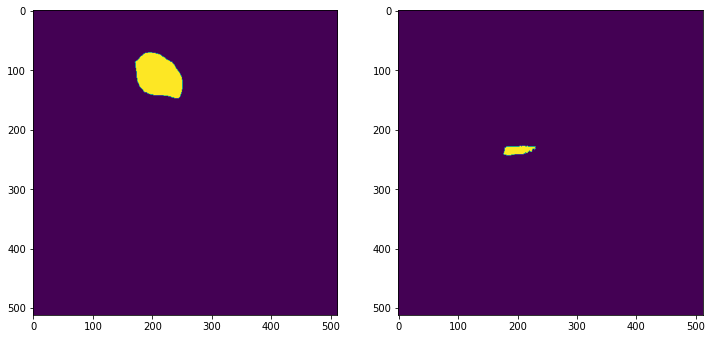

In [19]:
# train_loader의 output 결과(image 및 mask) 확인

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 12))
import numpy as np
i = 1
j = 30
mask1 = rle_to_mask(submission['EncodedPixels'][i].split(), (int(submission['Height'][i]), int(submission['Width'][i])))
mask2 = rle_to_mask(submission['EncodedPixels'][j].split(), (int(submission['Height'][j]), int(submission['Width'][j])))
print(mask1)


ax1.imshow(mutils.decode(json_data[i]['segmentation']))
ax1.grid(False)

ax2.imshow(mask2)
ax2.grid(False)

plt.show()